In [26]:
import json, time, urllib.parse
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import datetime
from dateutil.rrule import rrule, MONTHLY

In [44]:
# The number of months between October 2022 and January 2015
MONTH_BETWEEN = 94

# Step 1: Data Acquisition

Read in the csv file I dowloaded from https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/edit#gid=1345871712

In [2]:
df = pd.read_csv('dinosaur.csv')
df = df.iloc[1:]
df.head()

,name,url
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus
5,Abelisaurus,https://en.wikipedia.org/wiki/Abelisaurus


Set all necessary variables to access the correct endpoing to retrieve pageview information for 'all-access', 'desktop', 'mobile-app', and 'mobile-web'

In [3]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
# ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]
ARTICLE_TITLES = list(df['name'])

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.

access_param = ['all-access', 'desktop', 'mobile-app', 'mobile-web']

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_All_ACCESS = {
    "project":     "en.wikipedia.org",
    "access":      access_param[0],      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"    
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      access_param[1],      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"   
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      access_param[2],      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"    
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      access_param[3],      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"    
}


Function to return the json objects as a python dictionary for the specified endpoint

In [5]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  request_template = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Load in and write desktop user pageview request info to a JSON file

In [9]:

dict_desktop = {}
article = "dino_monthly_desktop_<start201501>-<end202210>.json"

for i in range(df.shape[0]):
    dict_desktop[ARTICLE_TITLES[i]] = []
    views = request_pageviews_per_article(ARTICLE_TITLES[i], 
                                          request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    
    strt_dt = datetime.date(2015,1,1)
    end_dt = datetime.date(int(views['items'][0]['timestamp'][0:4]), int(views['items'][0]['timestamp'][4:6]),1)
    dates_prepend = [0 for dt in rrule(MONTHLY, dtstart=strt_dt, until=end_dt)]
    dict_desktop[ARTICLE_TITLES[i]] += dates_prepend

    for month in views['items']:
        # Serializing json
#         del month["access"]
        dict_desktop[ARTICLE_TITLES[i]].append(month['views'])
            
with open(article, "w") as outfile:
    json_object = json.dumps(dict_desktop)
    outfile.write(json_object)

Load in and write cumulative user pageview request info to a JSON file

In [10]:
dict_cumulitive = {}
article = "dino_monthly_cumulative_<start201501>-<end202210>.json"

for i in range(df.shape[0]):
    dict_cumulitive[ARTICLE_TITLES[i]] = []
    views = request_pageviews_per_article(ARTICLE_TITLES[i], 
                                          request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_All_ACCESS)
    strt_dt = datetime.date(2015,1,1)
    end_dt = datetime.date(int(views['items'][0]['timestamp'][0:4]), int(views['items'][0]['timestamp'][4:6]),1)
    dates_prepend = [0 for dt in rrule(MONTHLY, dtstart=strt_dt, until=end_dt)]
    dict_cumulitive[ARTICLE_TITLES[i]] += dates_prepend
    
    for month in views['items']:
        # Serializing json
#         del month["access"]
        dict_cumulitive[ARTICLE_TITLES[i]].append(month['views'])
            
with open(article, "w") as outfile:
    json_object = json.dumps(dict_cumulitive)
    outfile.write(json_object)

Load in and write mobile user pageview request info to a JSON file

In [11]:
# write mobile info to JSON
dict_mobile = {}
article = "dino_monthly_mobile_<start201501>-<end202210>.json"

for i in range(df.shape[0]):
    dict_mobile[ARTICLE_TITLES[i]] = []
    views_app = request_pageviews_per_article(ARTICLE_TITLES[i], 
                                              request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    views_web = request_pageviews_per_article(ARTICLE_TITLES[i], 
                                              request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    
    strt_dt = datetime.date(2015,1,1)
    end_dt = datetime.date(int(views_app['items'][0]['timestamp'][0:4]), 
                           int(views_app['items'][0]['timestamp'][4:6]),1)
    dates_prepend = [0 for dt in rrule(MONTHLY, dtstart=strt_dt, until=end_dt)]
    dict_mobile[ARTICLE_TITLES[i]] += dates_prepend
    
    for j in range(len(views_app['items'])):
        # Serializing json
        dict_mobile[ARTICLE_TITLES[i]].append(int(views_app['items'][j]['views']) + 
                                               int(views_web['items'][j]['views']))
            
with open(article, "w") as outfile:
    json_object = json.dumps(dict_mobile)
    outfile.write(json_object)

# Step 2: Analysis

### Retrieve data from the three JSON files

In [12]:
# Opening JSON file
f_mobile = open('dino_monthly_mobile_<start201501>-<end202210>.json',)
f_cumulative = open('dino_monthly_cumulative_<start201501>-<end202210>.json',)
f_desktop = open('dino_monthly_desktop_<start201501>-<end202210>.json',)

   
# returns JSON object as a dictionary
mobile_dict = json.load(f_mobile)
cumulative_dict = json.load(f_cumulative)
desktop_dict = json.load(f_desktop)

# Closing file
f_mobile.close()
f_cumulative.close()
f_desktop.close()

### Maximum Average and Minimum Average 
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

Find the highest average page requests and lowest average page requests for desktop and mobile access

In [28]:
# Iterating through the jsonlist
max_mobile_index = None
max_mobile_average = -1

max_desktop_index = None
max_desktop_average = -1

min_mobile_index = None
min_mobile_average = float('inf')

min_desktop_index = None
min_desktop_average = float('inf')

for i, article in enumerate(ARTICLE_TITLES):
    average_mobile = sum(mobile_dict[article]) / np.count_nonzero(mobile_dict[article])
    
    if average_mobile > max_mobile_average:
        max_mobile_average = average_mobile
        max_mobile_index = i
    
    if average_mobile < min_mobile_average:
        min_mobile_average = average_mobile
        min_mobile_index = i
        
    average_desktop = sum(desktop_dict[article]) / np.count_nonzero(mobile_dict[article])
    
    if average_desktop > max_desktop_average:
        max_desktop_average = average_desktop
        max_desktop_index = i
    
    if average_desktop < min_desktop_average:
        min_desktop_average = average_desktop
        min_desktop_index = i

print('Max mobile article:', ARTICLE_TITLES[max_mobile_index])
print('Min mobile article:', ARTICLE_TITLES[min_mobile_index])
print('Max desktop article:', ARTICLE_TITLES[max_desktop_index])
print('Min desktop article:', ARTICLE_TITLES[min_desktop_index])

Max mobile article: Tyrannosaurus
Min mobile article: Honghesaurus
Max desktop article: Tyrannosaurus
Min desktop article: Honghesaurus


Graph the time-series that corresponds to the above four dinosaur articles

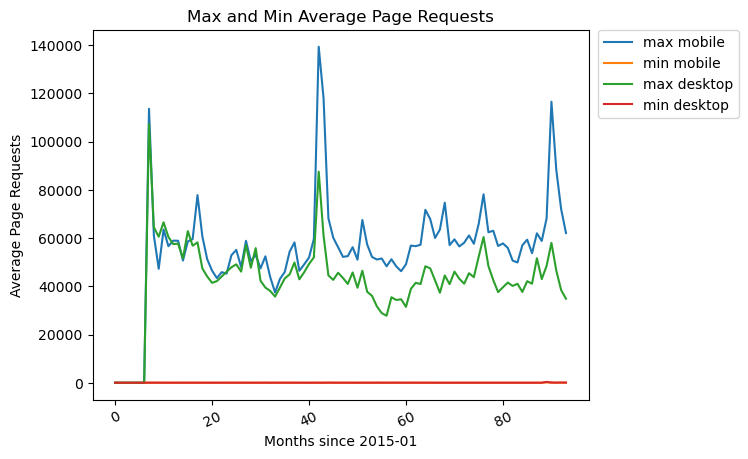

In [45]:
# creating data 12*8 
df = pd.DataFrame({'Months since 2015-01': [i for i in range(MONTH_BETWEEN)],
                     
                   'max_mobile': mobile_dict[ARTICLE_TITLES[max_mobile_index]],
                     
                   'min_mobile': mobile_dict[ARTICLE_TITLES[min_mobile_index]],
                     
                   'max_desktop': desktop_dict[ARTICLE_TITLES[max_desktop_index]],
                  
                   'min_desktop': desktop_dict[ARTICLE_TITLES[min_desktop_index]],})
  
# create the time series plot
sns.lineplot(x = "Months since 2015-01", y = "max_mobile", data = df, label= 'max mobile').set(title='Max and Min Average Page Requests')
sns.lineplot(x = "Months since 2015-01", y = "min_mobile", data = df, label= 'min mobile')
sns.lineplot(x = "Months since 2015-01", y = "max_desktop", data = df, label= 'max desktop')
sns.lineplot(x = "Months since 2015-01", y = "min_desktop", data = df, label= 'min desktop')
plt.ylabel("Average Page Requests")
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('step2_part1.png', bbox_inches='tight')

### Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Retrieve the top 10 peaks of mobile and desktop and their corresponding indexes in a tupple

In [31]:
largest_peak_mobile = []
largest_peak_desktop = []

for i, article in enumerate(ARTICLE_TITLES):
    largest_peak_mobile.append((max(mobile_dict[article]), i))
    largest_peak_desktop.append((max(desktop_dict[article]), i))

largest_peak_mobile = sorted(largest_peak_mobile, key=lambda x:x[0], reverse=True)
largest_peak_mobile = largest_peak_mobile[0:10]
largest_peak_desktop = sorted(largest_peak_desktop, key=lambda x:x[0], reverse=True)
largest_peak_desktop = largest_peak_desktop[0:10]

Graph the time-series that corresponds to the above 20 dinosaur articles

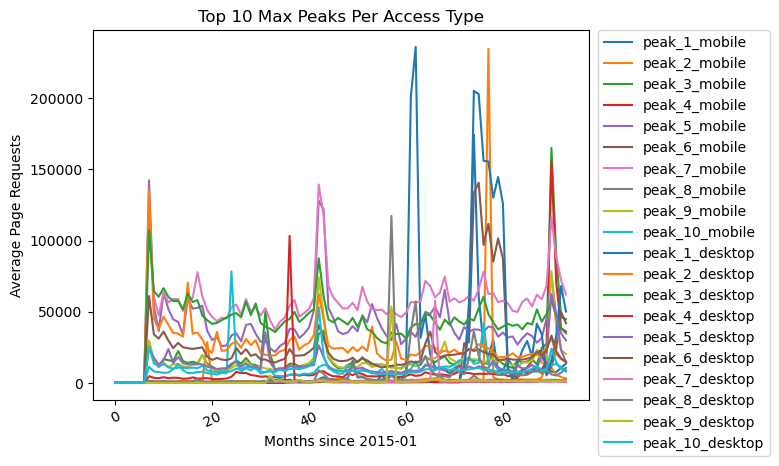

In [46]:
# creating data 12*8 
df = pd.DataFrame({'Months since 2015-01': [i for i in range(MONTH_BETWEEN)],
                     
                   'peak_1_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[0][1]]],
                   'peak_2_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[1][1]]],
                   'peak_3_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[2][1]]],
                   'peak_4_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[3][1]]],
                   'peak_5_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[4][1]]],
                   'peak_6_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[5][1]]],
                   'peak_7_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[6][1]]],
                   'peak_8_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[7][1]]],
                   'peak_9_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[8][1]]],
                   'peak_10_mobile': mobile_dict[ARTICLE_TITLES[largest_peak_mobile[9][1]]],
                     
                   'peak_1_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[0][1]]],
                   'peak_2_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[1][1]]],
                   'peak_3_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[2][1]]],
                   'peak_4_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[3][1]]],
                   'peak_5_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[4][1]]],
                   'peak_6_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[5][1]]],
                   'peak_7_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[6][1]]],
                   'peak_8_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[7][1]]],
                   'peak_9_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[8][1]]],
                   'peak_10_desktop': desktop_dict[ARTICLE_TITLES[largest_peak_desktop[9][1]]],})
  
# create the time series plot
sns.lineplot(x = "Months since 2015-01", y = "peak_1_mobile", data = df, label= 'peak_1_mobile').set(title='Top 10 Max Peaks Per Access Type')
sns.lineplot(x = "Months since 2015-01", y = "peak_2_mobile", data = df, label= 'peak_2_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_3_mobile", data = df, label= 'peak_3_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_4_mobile", data = df, label= 'peak_4_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_5_mobile", data = df, label= 'peak_5_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_6_mobile", data = df, label= 'peak_6_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_7_mobile", data = df, label= 'peak_7_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_8_mobile", data = df, label= 'peak_8_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_9_mobile", data = df, label= 'peak_9_mobile')
sns.lineplot(x = "Months since 2015-01", y = "peak_10_mobile", data = df, label= 'peak_10_mobile')

sns.lineplot(x = "Months since 2015-01", y = "peak_1_desktop", data = df, label= 'peak_1_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_2_desktop", data = df, label= 'peak_2_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_3_desktop", data = df, label= 'peak_3_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_4_desktop", data = df, label= 'peak_4_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_5_desktop", data = df, label= 'peak_5_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_6_desktop", data = df, label= 'peak_6_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_7_desktop", data = df, label= 'peak_7_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_8_desktop", data = df, label= 'peak_8_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_9_desktop", data = df, label= 'peak_9_desktop')
sns.lineplot(x = "Months since 2015-01", y = "peak_10_desktop", data = df, label= 'peak_10_desktop')
plt.ylabel("Average Page Requests")
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('step2_part2.png', bbox_inches='tight')

### Fewest Months of Data - 
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled. Your graph should possess a legend and a title. You must generate a .png or .jpeg formatted image of your final graph.


Find the 10 shorted time-series for desktop and mobile access

In [33]:
shortest_range_mobile = []
shortest_range_desktop = []

for i, article in enumerate(ARTICLE_TITLES):
    shortest_range_mobile.append((np.count_nonzero(mobile_dict[article]), i))
    shortest_range_desktop.append((np.count_nonzero(mobile_dict[article]), i))

shortest_range_mobile = sorted(shortest_range_mobile, key=lambda x:x[0])
shortest_range_mobile = shortest_range_mobile[0:10]
shortest_range_desktop = sorted(shortest_range_desktop, key=lambda x:x[0])
shortest_range_desktop = shortest_range_desktop[0:10]





Graph the time-series that corresponds to the above 20 dinosaur articles

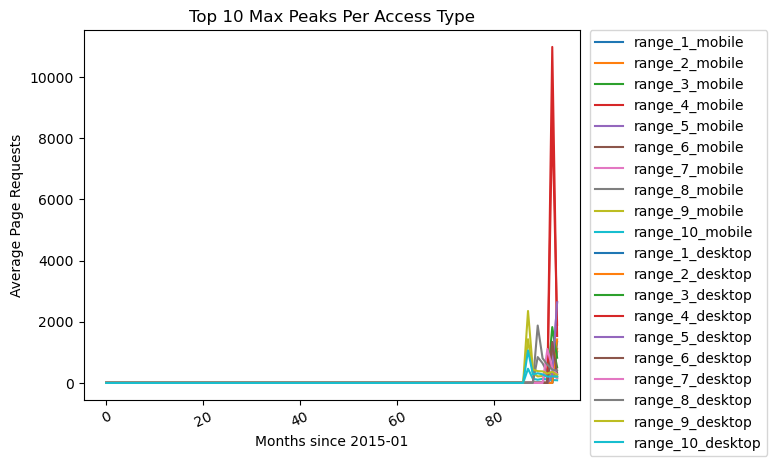

In [47]:
# creating data 12*8 
df = pd.DataFrame({'Months since 2015-01': [i for i in range(MONTH_BETWEEN)],
                     
                   'range_1_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[0][1]]],
                   'range_2_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[1][1]]],
                   'range_3_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[2][1]]],
                   'range_4_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[3][1]]],
                   'range_5_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[4][1]]],
                   'range_6_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[5][1]]],
                   'range_7_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[6][1]]],
                   'range_8_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[7][1]]],
                   'range_9_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[8][1]]],
                   'range_10_mobile': mobile_dict[ARTICLE_TITLES[shortest_range_mobile[9][1]]],
                     
                   'range_1_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[0][1]]],
                   'range_2_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[1][1]]],
                   'range_3_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[2][1]]],
                   'range_4_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[3][1]]],
                   'range_5_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[4][1]]],
                   'range_6_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[5][1]]],
                   'range_7_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[6][1]]],
                   'range_8_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[7][1]]],
                   'range_9_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[8][1]]],
                   'range_10_desktop': desktop_dict[ARTICLE_TITLES[shortest_range_desktop[9][1]]],})
  
# create the time series plot
sns.lineplot(x = "Months since 2015-01", y = "range_1_mobile", data = df, label= 'range_1_mobile').set(title='Top 10 Max Peaks Per Access Type')
sns.lineplot(x = "Months since 2015-01", y = "range_2_mobile", data = df, label= 'range_2_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_3_mobile", data = df, label= 'range_3_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_4_mobile", data = df, label= 'range_4_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_5_mobile", data = df, label= 'range_5_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_6_mobile", data = df, label= 'range_6_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_7_mobile", data = df, label= 'range_7_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_8_mobile", data = df, label= 'range_8_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_9_mobile", data = df, label= 'range_9_mobile')
sns.lineplot(x = "Months since 2015-01", y = "range_10_mobile", data = df, label= 'range_10_mobile')

sns.lineplot(x = "Months since 2015-01", y = "range_1_desktop", data = df, label= 'range_1_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_2_desktop", data = df, label= 'range_2_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_3_desktop", data = df, label= 'range_3_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_4_desktop", data = df, label= 'range_4_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_5_desktop", data = df, label= 'range_5_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_6_desktop", data = df, label= 'range_6_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_7_desktop", data = df, label= 'range_7_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_8_desktop", data = df, label= 'range_8_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_9_desktop", data = df, label= 'range_9_desktop')
sns.lineplot(x = "Months since 2015-01", y = "range_10_desktop", data = df, label= 'range_10_desktop')
plt.ylabel("Average Page Requests")
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('step2_part3.png', bbox_inches='tight')